# Object Detection



1.   Create a parent folder for custom model training and child folders to store data
2.   Prepare the dataset for model training and keep the following points in mind while preparing it
  *   This dataset contains many images, and depending on the compute power of the
VM, it might take a very long time to unzip this huge amount of data.
3. Create an CNN architecture for object detection of your choice to train an object detection model. Please note that algorithm or architecture selection is a very important aspect of ML model training, and you must pick the one that works the best for your dataset.
4. Evaluate the model and check the test results
5. Run inferences on sample images and see if vehicles are detected accurately


---



In this notebook, `YOLOv8` from `Ultralytics` is used on the custom dataset to detect the vehicles.


**Steps:**


1. Vehicle dataset preparation to train `YOLOv8`
2. Setting Up `YOLOv8` to Train on Custom Dataset
3. Train `YOLOv8` on the Custom Vehicle Detection Dataset
4. `YOLOv8` Small Training on the Vehicle Detection Dataset
5. Inference using the Trained `YOLOv8` Model
6. Summary and Conclusion



## 1. Vehicle dataset preparation to train `YOLOv8`



> Import necessary libraries for dataset preparation

In [1]:
import numpy as np
import pandas as pd
import cv2
import shutil
import os
import glob
import random

> Change runtime type to `T4 GPU`. Check whether it is changed.

In [2]:
!nvidia-smi

Sat Aug 17 17:36:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Observation**

GPU is connected.

> Check device name and assign it to a variable `gpu_id`, which can be used later while training `YOLOv8` model.

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

gpu_id = device_name.split(':')[2]
print(f"GPU ID is: {gpu_id}")

Found GPU at: /device:GPU:0
GPU ID is: 0


> As this project is developed in `Google Colab`, connect to the drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> Get the paths for the data, i.e., images zip folder and labels

In [5]:
img_zip = "/content/drive/MyDrive/PGC AIML/Capstone/Images.zip"
label_path = "/content/drive/MyDrive/PGC AIML/Capstone/labels.csv"

> - Unzip the images folder and save
- Images are saved in `Images` folder.

In [6]:
shutil.unpack_archive(img_zip)
img_dir = "Images/"

> Load label data

In [7]:
labels_df = pd.read_csv(label_path, header=None)
labels_df.head()

,0,1,2,3,4,5
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45


Labels are in the form on `img_id`, `label`, `x_min`, `y_min`, `x_max` and `y_max`. Assign these as column names to the label data.

> Assign columns to the label data

In [8]:
labels_df.columns = ['img_id', 'label', 'x_min', 'y_min', 'x_max', 'y_max']
labels_df.head()

,img_id,label,x_min,y_min,x_max,y_max
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45


> Sort the label data by `img_id`

In [9]:
labels_df.sort_values(by='img_id')
labels_df.head()

,img_id,label,x_min,y_min,x_max,y_max
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45


> Convert the data types of `x_min`, `y_min`, `x_max` and `y_max` to `float` to further modify these to be compatible with `YOLOv8` data format.

In [10]:
labels_df[['x_min', 'y_min', 'x_max', 'y_max']] = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].astype('float')
labels_df.head()

,img_id,label,x_min,y_min,x_max,y_max
0,0,pickup_truck,213.0,34.0,255.0,50.0
1,0,car,194.0,78.0,273.0,122.0
2,0,car,155.0,27.0,183.0,35.0
3,0,articulated_truck,43.0,25.0,109.0,55.0
4,0,car,106.0,32.0,124.0,45.0


> Check both the image data and label data to make sure they are aligned with each other.

In [11]:
# Get the filenames in a list
lst = os.listdir(img_dir)

# Sort the list
lst.sort()

# Get the number of files
number_files = len(lst)

# Print the results
print(f"Total number of images : {number_files}")
print(f"Last image filename : {lst[-1]}")

Total number of images : 5626
Last image filename : 00005657.jpg


Last image filename in the data is `00005657.jpg`.
Check whether label data has the image file as the last one.

In [12]:
labels_df['img_id'].tail(1)

,img_id
351548,110592


Last image name in the label data is `1105952`.
Consider label data until the image name `00005657.jpg`, i.e., `5657` in the label `img_id`. Discard reamining label data as images for them are unavailable.

In [13]:
labels_temp = labels_df[labels_df['img_id'] <= 5657]
print(f"Total number of labels for the available image data : {len(labels_temp)}")

Total number of labels for the available image data : 17967


> Get the `classes` and map them to the `class_id` to encode them as they are categorical.

In [14]:
class_ids = list(labels_temp['label'].unique())

print("Classes:")
class_ids

Classes:


['pickup_truck',
 'car',
 'articulated_truck',
 'bus',
 'motorized_vehicle',
 'work_van',
 'single_unit_truck',
 'pedestrian',
 'bicycle',
 'non-motorized_vehicle',
 'motorcycle']

> Get the class mapping

In [15]:
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'pickup_truck',
 1: 'car',
 2: 'articulated_truck',
 3: 'bus',
 4: 'motorized_vehicle',
 5: 'work_van',
 6: 'single_unit_truck',
 7: 'pedestrian',
 8: 'bicycle',
 9: 'non-motorized_vehicle',
 10: 'motorcycle'}

> Check label data for the number of classes and number of samples in each class

In [16]:
labels_temp['label'].value_counts()

,count
label,
car,12076
pickup_truck,2136
motorized_vehicle,1295
bus,561
work_van,462
articulated_truck,461
pedestrian,340
single_unit_truck,303
bicycle,130


**Observation**

There is data imbalance in the labels. Due to data imbalance and hardware constraints, entire data cannot be used for training.

> Consider a part of dataset for the modelling

> Consider maximum number per class as `500`

> Get the corresponding indices for label data

In [17]:
MAX_NUM_SAMPLES_PER_CLASS = 500

indices = []
for id in range(len(class_ids)):
  class_indices = labels_temp[labels_temp['label']==class_ids[id]].index.values.tolist()
  # print(class_ids[i], len(class_data))
  if len(class_indices) < MAX_NUM_SAMPLES_PER_CLASS:
    indices.extend(class_indices)
  else:
    np.random.seed(42)  # Set random seed for reproducibility
    index = (np.random.choice(len(class_indices), MAX_NUM_SAMPLES_PER_CLASS, replace=False).astype('int64')).tolist()
    # print(type(index), index.dtype, index.shape)
    current_indices = [class_indices[i] for i in index]
    indices.extend(current_indices)

print(f"Number of considered labels: {len(indices)}")

Number of considered labels: 3899


> Sort the labels and get the final label data for modeling.

In [18]:
indices_sorted = sorted(indices)
labels_final = labels_temp.loc[indices_sorted]

# Reset index of labels_final
labels_final = labels_final.reset_index(drop=True)
labels_final.head()

,img_id,label,x_min,y_min,x_max,y_max
0,0,articulated_truck,43.0,25.0,109.0,55.0
1,1,bus,205.0,155.0,568.0,314.0
2,4,bus,439.0,32.0,719.0,171.0
3,5,articulated_truck,132.0,3.0,712.0,254.0
4,9,car,109.0,42.0,142.0,66.0


> Check number of labels considered for each class

In [19]:
labels_final['label'].value_counts()

,count
label,
bus,500
car,500
motorized_vehicle,500
pickup_truck,500
work_van,462
articulated_truck,461
pedestrian,340
single_unit_truck,303
bicycle,130


> Check whether the label data is duplicated

In [20]:
labels_final.duplicated().sum()

0

**Observation**

There are no duplicates.

> Check for missing labels

In [21]:
labels_final.isna().sum()

,0
img_id,0
label,0
x_min,0
y_min,0
x_max,0
y_max,0


**Observation**

There are no missing values.

> Check for `null` labels

In [22]:
labels_final.isnull().sum()

,0
img_id,0
label,0
x_min,0
y_min,0
x_max,0
y_max,0


**Observation**

There are no null values.

Images and label datasets are made aligned with each other.

Now, this data has to be prepared in the `YOLO` data format as below.

```
Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/vehicleDataset  # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')
test:  # test images (optional)

```

> Get the samples for `train` and `valid` datasets.

> Note that `test` dataset is not considered for this project due to hardware constrainta.

In [23]:
total_labels = len(labels_final['img_id'].unique())

num_train_samples = total_labels * 0.8
num_train_samples = int(num_train_samples // 1)

num_valid_samples = total_labels - num_train_samples

print(f"Total number of labels : {total_labels}")
print(f"Total number of train samples : {num_train_samples}")
print(f"Total number of valid samples : {num_valid_samples}")

Total number of labels : 2584
Total number of train samples : 2067
Total number of valid samples : 517


> Get the root directory path as `YOLOv8` gets data from the root directory

In [24]:
root_dir = os.getcwd()
print(f"Root directory for this project: {root_dir}")

Root directory for this project: /content


> Create the directories for the `train` and `valid` datasets according to the `YOLOv8` format.

In [25]:
def createDirectory(path):
  if not os.path.exists(path):
    os.makedirs(path, exist_ok=True)  # Use makedirs to create parent directories if needed
    print(f"Directory '{path}' created successfully.")
  else:
    print(f"Directory '{path}' already exists.")
    return

In [26]:
createDirectory(root_dir + '/datasets/vehicleDataset/images/train')
createDirectory(root_dir + '/datasets/vehicleDataset/images/valid')
createDirectory(root_dir + '/datasets/vehicleDataset/labels/train')
createDirectory(root_dir + '/datasets/vehicleDataset/labels/valid')

Directory '/content/datasets/vehicleDataset/images/train' created successfully.
Directory '/content/datasets/vehicleDataset/images/valid' created successfully.
Directory '/content/datasets/vehicleDataset/labels/train' created successfully.
Directory '/content/datasets/vehicleDataset/labels/valid' created successfully.


> Prepare `train` and `valid` datasets according to the `YOLOv8` format.

> `YOLOv8` bounding box format is `cx, cy, width, height`

> `x_min`, `y_min`, `x_max` and `y_max` are used to create `cx, cy, width, height` format for bounding boxes.

In [27]:
# from google.colab.patches import cv2_imshow
images = []

max_label = 0 # Label data from here can be discarded.
lables_original = labels_final.copy()

# Convert the `img_id` to mtach the actual image names
labels_final['img_id'] = labels_final['img_id'].apply(lambda x: f"{x:08d}")

print('Loaded ')

img_count = 0

for i, img_id in enumerate(labels_final['img_id'].unique()):

  # To display the progress
  if i%1000 == 0:
    print(str(i), end = '\n')
  elif i%100 == 0:
    print(str(i), end = ' ')

  img_path = img_dir + img_id + '.jpg'
  img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)

  if img is not None:

    d = np.array(labels_final[labels_final['img_id']==img_id][['x_min', 'y_min', 'x_max', 'y_max']])

    factor = np.array([1., 1., 1., 1.]) / np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    bbs = factor * np.array(labels_final[labels_final['img_id']==img_id][['x_min', 'y_min', 'x_max', 'y_max']])
    labels = (labels_final[labels_final['img_id']==img_id]['label']).tolist()

    keys = []
    for l in range(len(labels)):
      key = [val for val in class_mapping if class_mapping[val]==labels[l]][0]
      keys.append(key)

    if img_count < num_train_samples:
      img_path = root_dir + '/datasets/vehicleDataset/images/train/'
      label_path = root_dir + '/datasets/vehicleDataset/labels/train/'
    else:
      img_path = root_dir + '/datasets/vehicleDataset/images/valid/'
      label_path = root_dir + '/datasets/vehicleDataset/labels/valid/'

    with open(label_path + img_id + '.txt', 'a') as f:
      if len(keys) == 0:
        continue
      else:
        cv2.imwrite(img_path + img_id + '.jpg', img)
        for line in range(len(keys)):
          x, y, w, h = (d[line][0] + d[line][2])/2, (d[line][1] + d[line][3])/2, d[line][2] - d[line][0], d[line][3] - d[line][1]
          x = x/img.shape[1]
          y = y/img.shape[0]
          w = w/img.shape[1]
          h = h/img.shape[0]
          if line != len(keys)-1:
            f.writelines(str(keys[line]) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h)+'\n')
          else:
            f.writelines(str(keys[line]) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h))
  else:
    print(f"There are no images available starting from {img_id}.jpg")
    print(img_id, i)
    max_label = i-1 # Label data from here can be discarded.
    break

  img_count += 1

Loaded 
0
100 200 300 400 500 600 700 800 900 1000
1100 1200 1300 1400 1500 1600 1700 1800 1900 2000
2100 2200 2300 2400 2500 

> `vehicleDataset.yaml` is as below.

```
path: vehicleDataset/
train: 'images/train'
val: 'images/valid'

# class names
names:
  0: 'pickup_truck'
  1: 'car'
  2: 'articulated_truck'
  3: 'bus'
  4: 'motorized_vehicle'
  5: 'work_van'
  6: 'single_unit_truck'
  7: 'pedestrian'
  8: 'bicycle'
  9: 'non-motorized_vehicle'
  10: 'motorcycle'
```

Now, dataset is prepared in the `YOLOv8` format.

## 2. Setting Up `YOLOv8` to Train on Custom Dataset

To train `YOLOv8` on a custom dataset,`ultralytics` package should be installed.

In [28]:
!pip install ultralytics

from IPython import display
display.clear_output() # Clear the output

`Ultralytics` is installed successfully.

## 3. Train `YOLOv8` on the Custom Vehicle Detection Dataset

`YOLOv8` small version, i.e., `yolov8s.pt` is used for training due to hardware constraints.

Here are a few pointers explaining the hyperparameter choices used while training:

1. `YOLOv8s` model is trained for `100` epochs. As a concept project, to get started, we will try to get the best possible results with limited training. As we have almost `2500` images, even `200` epochs will take quite some time to train and should give decent results.
2. Batch size is to `8` in all the experiments,
3. As the vehicles can be quite small in some images, image size can be set to `1280` resolution while training. Although this will increase the training time, better results can be expected compared to the default `640` image resolution training. But here, `640` is used due to hardware constraints.

Here are the explanations of all the command line arguments that are used:

- `model`: The model that we want to use. Here, we use the `YOLOv8` Small model pretrained on the COCO dataset.
- `data`: Path to the dataset YAML file.
- `epochs`: Number of epochs we want to train for.
- `imgsz`: The image size `640` is used.. The default resolution is `640`.
- `batch`: The batch size for data loader. It can be increased or decreased according to GPU memory availability.
-`device`: GPU id.
- `name`: Name of the results directory for `runs/detect`.

In [29]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8s.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/drive/MyDrive/PGC AIML/Capstone/vehicleDataset.yaml",
                      epochs=100,
                      imgsz=640,
                      batch=8,
                      device=gpu_id,
                      name='yolov8s_vehicle')

100%|██████████| 21.5M/21.5M [00:00<00:00, 103MB/s] 


Ultralytics YOLOv8.2.78 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PGC AIML/Capstone/vehicleDataset.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8s_vehicle, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

100%|██████████| 755k/755k [00:00<00:00, 20.6MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 107MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/vehicleDataset/labels/train... 2067 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2067/2067 [00:03<00:00, 547.94it/s]

train: New cache created: /content/datasets/vehicleDataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/vehicleDataset/labels/valid... 517 images, 0 backgrounds, 0 corrupt: 100%|██████████| 517/517 [00:01<00:00, 483.65it/s]

val: New cache created: /content/datasets/vehicleDataset/labels/valid.cache


Plotting labels to runs/detect/yolov8s_vehicle/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_vehicle
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.45G      1.247      3.757      1.208         10        640: 100%|██████████| 259/259 [01:03<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.82it/s]

                   all        517        791      0.267      0.319      0.243      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.35G      1.235      2.408      1.202          6        640: 100%|██████████| 259/259 [01:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.23it/s]


                   all        517        791      0.446      0.328      0.264      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.37G      1.271      2.258       1.22         10        640: 100%|██████████| 259/259 [00:54<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.77it/s]

                   all        517        791       0.49      0.347      0.305      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.38G      1.245      2.199      1.223          7        640: 100%|██████████| 259/259 [00:53<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.17it/s]

                   all        517        791       0.46      0.364      0.338       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.38G      1.227      2.067      1.201          7        640: 100%|██████████| 259/259 [00:53<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.20it/s]


                   all        517        791      0.445      0.344      0.343       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.33G      1.193      1.982      1.194          5        640: 100%|██████████| 259/259 [00:56<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.59it/s]


                   all        517        791      0.586      0.398      0.375      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.38G      1.159      1.923      1.156          2        640: 100%|██████████| 259/259 [01:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.50it/s]

                   all        517        791      0.388      0.416      0.396      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.36G      1.149      1.832      1.168          5        640: 100%|██████████| 259/259 [00:57<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.57it/s]


                   all        517        791      0.621      0.371      0.378      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.39G      1.127       1.76      1.143         13        640: 100%|██████████| 259/259 [01:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.45it/s]


                   all        517        791      0.668      0.381      0.392      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.36G      1.097      1.728      1.123         11        640: 100%|██████████| 259/259 [00:57<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.65it/s]


                   all        517        791      0.531      0.419      0.431      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.38G      1.088      1.664      1.126          4        640: 100%|██████████| 259/259 [01:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.55it/s]

                   all        517        791      0.475      0.467      0.428      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.36G      1.063      1.606      1.107          7        640: 100%|██████████| 259/259 [00:55<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.28it/s]


                   all        517        791      0.417      0.477      0.433      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.39G      1.052      1.548      1.097          9        640: 100%|██████████| 259/259 [00:55<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.33it/s]


                   all        517        791      0.421      0.454      0.443      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.36G      1.045      1.578      1.092         12        640: 100%|██████████| 259/259 [00:53<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.63it/s]

                   all        517        791      0.608       0.45      0.452       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.38G      1.035      1.531      1.097          5        640: 100%|██████████| 259/259 [00:54<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.53it/s]

                   all        517        791      0.474      0.477      0.458       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.38G      1.025      1.531      1.092          4        640: 100%|██████████| 259/259 [00:55<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]


                   all        517        791      0.467      0.476      0.459      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.39G      1.024      1.454      1.077          6        640: 100%|██████████| 259/259 [00:52<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.54it/s]

                   all        517        791      0.598      0.477      0.465      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.36G      1.017      1.453      1.081         14        640: 100%|██████████| 259/259 [00:55<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.52it/s]


                   all        517        791      0.494       0.48      0.446      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.38G     0.9973       1.39      1.062          5        640: 100%|██████████| 259/259 [00:52<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.78it/s]


                   all        517        791      0.551      0.477      0.467      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.36G     0.9923      1.383      1.068         14        640: 100%|██████████| 259/259 [00:57<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.06it/s]

                   all        517        791      0.521      0.489      0.466      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.39G     0.9834      1.366      1.066          9        640: 100%|██████████| 259/259 [00:55<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.97it/s]


                   all        517        791      0.551      0.465      0.481      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.36G     0.9701      1.309      1.054          7        640: 100%|██████████| 259/259 [00:55<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  6.69it/s]

                   all        517        791      0.487      0.511      0.489      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.38G     0.9421      1.299       1.04          7        640: 100%|██████████| 259/259 [00:58<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.64it/s]

                   all        517        791      0.504      0.493      0.493      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.37G     0.9588      1.312      1.059          9        640: 100%|██████████| 259/259 [00:55<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.70it/s]


                   all        517        791      0.539      0.471      0.469      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.39G     0.9507      1.284      1.043          6        640: 100%|██████████| 259/259 [00:59<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.04it/s]


                   all        517        791      0.514      0.561       0.51      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.36G     0.9474       1.27      1.045          6        640: 100%|██████████| 259/259 [00:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.47it/s]


                   all        517        791      0.522      0.498      0.497       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.38G     0.9477      1.248      1.043          7        640: 100%|██████████| 259/259 [00:57<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.68it/s]


                   all        517        791      0.512      0.553      0.501      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.36G     0.9293      1.214      1.032          9        640: 100%|██████████| 259/259 [00:52<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.46it/s]


                   all        517        791       0.49      0.542      0.505      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.38G     0.9139      1.208      1.026          5        640: 100%|██████████| 259/259 [00:58<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.79it/s]


                   all        517        791      0.518      0.538      0.505      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.36G     0.8969      1.206      1.017         11        640: 100%|██████████| 259/259 [00:55<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.57it/s]

                   all        517        791      0.515      0.531      0.522      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.37G     0.8923      1.171      1.016          8        640: 100%|██████████| 259/259 [00:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.45it/s]

                   all        517        791      0.581      0.523      0.526      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.38G     0.8999      1.165      1.021         11        640: 100%|██████████| 259/259 [00:54<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]

                   all        517        791      0.554      0.499      0.519      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.38G     0.8962      1.132      1.015          8        640: 100%|██████████| 259/259 [00:53<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.61it/s]

                   all        517        791      0.516      0.538      0.509      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.38G     0.8772      1.105      1.002         10        640: 100%|██████████| 259/259 [00:58<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.94it/s]


                   all        517        791      0.551      0.558      0.528      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.38G     0.8629       1.08     0.9983          6        640: 100%|██████████| 259/259 [00:55<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all        517        791      0.539      0.529      0.513      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.36G     0.8625      1.075     0.9994          9        640: 100%|██████████| 259/259 [00:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.81it/s]


                   all        517        791      0.535      0.542      0.536      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.38G     0.8746      1.056      1.003         13        640: 100%|██████████| 259/259 [00:54<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.89it/s]


                   all        517        791      0.568      0.527       0.53      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.35G     0.8614      1.067     0.9938          8        640: 100%|██████████| 259/259 [00:57<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.45it/s]

                   all        517        791      0.491      0.551      0.504      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.38G     0.8524      1.057     0.9969          7        640: 100%|██████████| 259/259 [00:54<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.10it/s]

                   all        517        791      0.573      0.511      0.519      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.37G     0.8505      1.024     0.9924          9        640: 100%|██████████| 259/259 [00:59<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.61it/s]

                   all        517        791      0.519       0.55      0.534      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.39G     0.8348     0.9938       0.99          4        640: 100%|██████████| 259/259 [00:55<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.75it/s]


                   all        517        791      0.546      0.546      0.526      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.38G      0.836     0.9771     0.9776         13        640: 100%|██████████| 259/259 [00:57<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.26it/s]

                   all        517        791      0.552      0.547      0.539       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.38G     0.8223     0.9705     0.9767          5        640: 100%|██████████| 259/259 [00:55<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.76it/s]


                   all        517        791       0.52      0.539      0.511      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.38G     0.8281     0.9607     0.9916          6        640: 100%|██████████| 259/259 [00:55<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.09it/s]

                   all        517        791      0.561      0.533      0.518      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.36G     0.8344     0.9673      0.985          2        640: 100%|██████████| 259/259 [00:59<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.77it/s]


                   all        517        791      0.533      0.561      0.522      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.36G      0.809     0.9496     0.9756          8        640: 100%|██████████| 259/259 [00:56<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.71it/s]

                   all        517        791      0.541      0.555      0.533      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.38G     0.8082     0.9258     0.9757          7        640: 100%|██████████| 259/259 [00:59<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.02it/s]

                   all        517        791      0.524      0.564       0.53       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.38G     0.7952     0.9225     0.9698          9        640: 100%|██████████| 259/259 [00:53<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.51it/s]

                   all        517        791      0.576      0.519      0.522      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.39G     0.7983     0.9029     0.9689          9        640: 100%|██████████| 259/259 [00:55<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.94it/s]


                   all        517        791      0.497      0.555      0.523      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.38G     0.7971     0.9004     0.9692          8        640: 100%|██████████| 259/259 [00:54<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.51it/s]

                   all        517        791      0.544      0.569      0.532      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G     0.7894      0.886     0.9717         10        640: 100%|██████████| 259/259 [00:58<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.66it/s]


                   all        517        791      0.545      0.544      0.534       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.38G     0.7947     0.8706     0.9685          6        640: 100%|██████████| 259/259 [00:53<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all        517        791      0.564      0.511      0.523      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.37G      0.777     0.8665     0.9581          8        640: 100%|██████████| 259/259 [00:59<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.69it/s]


                   all        517        791      0.561      0.533      0.538      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.36G     0.7716      0.842     0.9603          7        640: 100%|██████████| 259/259 [00:55<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.60it/s]


                   all        517        791      0.576      0.555      0.528      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.37G     0.7617     0.8284     0.9587          3        640: 100%|██████████| 259/259 [00:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.75it/s]


                   all        517        791      0.572      0.548      0.537      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.38G     0.7693     0.8203     0.9532          3        640: 100%|██████████| 259/259 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.83it/s]


                   all        517        791      0.517      0.583      0.532      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.37G       0.77      0.817     0.9577          9        640: 100%|██████████| 259/259 [00:56<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.16it/s]


                   all        517        791      0.555      0.555      0.546      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.38G     0.7516      0.782     0.9515         10        640: 100%|██████████| 259/259 [00:54<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.88it/s]

                   all        517        791      0.578      0.532      0.527      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.38G     0.7439      0.773     0.9443          8        640: 100%|██████████| 259/259 [00:56<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.91it/s]


                   all        517        791      0.565      0.532      0.533      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.38G     0.7492     0.7724     0.9456         13        640: 100%|██████████| 259/259 [00:57<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.67it/s]


                   all        517        791      0.569      0.521      0.528      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.38G     0.7501     0.7698     0.9527          7        640: 100%|██████████| 259/259 [00:56<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.73it/s]


                   all        517        791      0.535      0.551      0.537      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.35G     0.7546     0.7826     0.9643          4        640: 100%|██████████| 259/259 [00:58<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.82it/s]


                   all        517        791      0.574      0.551      0.546      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.36G     0.7439     0.7596     0.9464          8        640: 100%|██████████| 259/259 [00:56<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.80it/s]


                   all        517        791      0.537      0.555      0.526      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.38G     0.7372     0.7465     0.9441          5        640: 100%|██████████| 259/259 [01:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  6.99it/s]

                   all        517        791      0.567      0.547      0.532      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.39G     0.7269     0.7312     0.9372          7        640: 100%|██████████| 259/259 [00:54<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.25it/s]

                   all        517        791      0.532      0.568      0.544      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.38G     0.7239     0.7225     0.9421         13        640: 100%|██████████| 259/259 [00:57<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.35it/s]


                   all        517        791      0.576      0.533      0.535      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.38G     0.7045     0.7065     0.9328          9        640: 100%|██████████| 259/259 [00:54<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.27it/s]

                   all        517        791      0.525      0.583      0.547      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.38G     0.6894     0.6941     0.9359          8        640: 100%|██████████| 259/259 [00:58<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  6.87it/s]


                   all        517        791      0.592      0.529      0.536      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.36G     0.6983     0.6871     0.9311          8        640: 100%|██████████| 259/259 [00:55<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.41it/s]

                   all        517        791       0.53      0.567      0.532      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.34G     0.6905     0.6854     0.9364          8        640: 100%|██████████| 259/259 [00:59<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


                   all        517        791      0.535      0.578      0.528      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.36G     0.7022     0.6845     0.9305          9        640: 100%|██████████| 259/259 [00:54<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]

                   all        517        791      0.557      0.526      0.519      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.38G     0.6964     0.6765     0.9223          9        640: 100%|██████████| 259/259 [00:57<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.19it/s]


                   all        517        791      0.531      0.561      0.526      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.38G     0.6837     0.6692     0.9351         12        640: 100%|██████████| 259/259 [00:52<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.49it/s]


                   all        517        791      0.545      0.548      0.522      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.36G     0.6771     0.6605     0.9191         11        640: 100%|██████████| 259/259 [00:57<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.31it/s]

                   all        517        791      0.539      0.534      0.523      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.38G     0.6827     0.6428     0.9252          9        640: 100%|██████████| 259/259 [00:57<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.30it/s]

                   all        517        791      0.578      0.516      0.521      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.38G     0.6833     0.6475     0.9267          6        640: 100%|██████████| 259/259 [01:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.32it/s]


                   all        517        791      0.568      0.544      0.526      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.38G     0.6703     0.6337     0.9211          6        640: 100%|██████████| 259/259 [00:55<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.67it/s]


                   all        517        791      0.592      0.538      0.538      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.35G     0.6806     0.6148     0.9269          8        640: 100%|██████████| 259/259 [00:59<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.73it/s]


                   all        517        791      0.548      0.574      0.544      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.38G     0.6617     0.6147     0.9232          7        640: 100%|██████████| 259/259 [00:54<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.66it/s]


                   all        517        791      0.571      0.548      0.539      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.37G     0.6592     0.6112     0.9176          6        640: 100%|██████████| 259/259 [00:57<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.89it/s]

                   all        517        791      0.571      0.541       0.54      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G     0.6549      0.596     0.9166         11        640: 100%|██████████| 259/259 [00:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.81it/s]

                   all        517        791       0.56      0.547      0.529      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.38G     0.6672     0.5994     0.9156          6        640: 100%|██████████| 259/259 [00:59<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.62it/s]

                   all        517        791      0.548      0.559      0.533      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.38G     0.6607     0.6025     0.9128          9        640: 100%|██████████| 259/259 [00:55<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.03it/s]

                   all        517        791      0.574      0.542      0.532      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.39G     0.6479     0.6016     0.9128         12        640: 100%|██████████| 259/259 [00:59<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.24it/s]

                   all        517        791      0.536      0.566      0.536      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.38G     0.6424     0.5841     0.9118         18        640: 100%|██████████| 259/259 [00:52<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.83it/s]


                   all        517        791      0.605      0.497      0.536      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.35G     0.6317     0.5584     0.9051          8        640: 100%|██████████| 259/259 [00:55<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.27it/s]

                   all        517        791       0.53      0.571       0.54      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.36G     0.6285     0.5704     0.9103          8        640: 100%|██████████| 259/259 [00:52<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.57it/s]


                   all        517        791      0.572      0.561      0.543      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.37G     0.6272     0.5583     0.9026         13        640: 100%|██████████| 259/259 [00:58<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.04it/s]

                   all        517        791      0.554      0.562      0.545      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.39G      0.629     0.5592     0.9134          8        640: 100%|██████████| 259/259 [00:53<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  6.03it/s]


                   all        517        791      0.559      0.567      0.537      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.39G      0.621     0.5575     0.9027         14        640: 100%|██████████| 259/259 [00:55<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.41it/s]


                   all        517        791      0.558      0.547      0.537      0.395
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.36G     0.6067     0.4878      0.876          8        640: 100%|██████████| 259/259 [00:53<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.79it/s]

                   all        517        791      0.565      0.529      0.526      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.38G     0.5927     0.4642     0.8675          6        640: 100%|██████████| 259/259 [00:54<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]

                   all        517        791      0.546      0.548      0.534      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.36G     0.5786     0.4503     0.8629          4        640: 100%|██████████| 259/259 [00:52<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.60it/s]

                   all        517        791      0.559      0.533      0.525      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.36G      0.574     0.4438     0.8681          3        640: 100%|██████████| 259/259 [00:53<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.40it/s]


                   all        517        791      0.574       0.53      0.532      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.38G     0.5702     0.4434     0.8668          3        640: 100%|██████████| 259/259 [00:51<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.92it/s]

                   all        517        791      0.555      0.551      0.532      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.38G     0.5713     0.4316     0.8639          3        640: 100%|██████████| 259/259 [00:50<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.25it/s]

                   all        517        791      0.543       0.55      0.529      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.39G     0.5656     0.4307     0.8609          4        640: 100%|██████████| 259/259 [00:52<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.01it/s]


                   all        517        791      0.548      0.564      0.534      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.36G     0.5562     0.4252     0.8625          8        640: 100%|██████████| 259/259 [00:55<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.37it/s]

                   all        517        791      0.575      0.557      0.534      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.37G     0.5507     0.4158     0.8575          4        640: 100%|██████████| 259/259 [00:52<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:04<00:00,  7.35it/s]

                   all        517        791      0.561      0.555      0.533      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.36G     0.5565     0.4115     0.8572          3        640: 100%|██████████| 259/259 [00:53<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]


                   all        517        791      0.577      0.547      0.534      0.399

100 epochs completed in 1.746 hours.
Optimizer stripped from runs/detect/yolov8s_vehicle/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_vehicle/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_vehicle/weights/best.pt...
Ultralytics YOLOv8.2.78 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.80it/s]


                   all        517        791      0.572      0.561      0.543      0.402
          pickup_truck         86         91      0.408      0.473      0.381      0.323
                   car         99        106      0.111     0.0943     0.0649      0.045
     articulated_truck         69         80      0.807      0.812       0.83       0.64
                   bus         85         97      0.845      0.897      0.873        0.8
     motorized_vehicle        101        110       0.28      0.255      0.147     0.0684
              work_van         94         97      0.717       0.68        0.7      0.565
     single_unit_truck         56         59      0.581       0.61      0.618      0.481
            pedestrian         43         86      0.647      0.384      0.469      0.211
               bicycle         21         25      0.656        0.8      0.766      0.546
 non-motorized_vehicle         18         18      0.413      0.389      0.332      0.218
            motorcycl

## 5. Inference using the Trained `YOLOv8` Small Custom Model

In [30]:
# Load a trained model
model = YOLO("runs/detect/yolov8s_vehicle/weights/last.pt")  # pretrained YOLOv8s model
# model = YOLO('yolov8s.pt')

imgs_path = root_dir + '/datasets/vehicleDataset/images/valid/'
valImgs = os.listdir(imgs_path)

# List of images
imgs = valImgs[0:10]
imgs = [imgs_path + img for img in imgs]
print([img for img in imgs])

# Run batched inference on a list of images
results = model(imgs)  # return a list of Results objects

# Check if the directory exists before creating it
createDirectory(root_dir + '/results')

# Process results list
i = 0
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    # result.show()  # display to screen
    # result.save(filename="result.jpg")
    filename = root_dir + "/results/" + valImgs[i]
    print(filename)
    result.save(filename=filename)  # save to disk
    i += 1

['/content/datasets/vehicleDataset/images/valid/00005128.jpg', '/content/datasets/vehicleDataset/images/valid/00005047.jpg', '/content/datasets/vehicleDataset/images/valid/00004743.jpg', '/content/datasets/vehicleDataset/images/valid/00005043.jpg', '/content/datasets/vehicleDataset/images/valid/00004628.jpg', '/content/datasets/vehicleDataset/images/valid/00004635.jpg', '/content/datasets/vehicleDataset/images/valid/00004772.jpg', '/content/datasets/vehicleDataset/images/valid/00005368.jpg', '/content/datasets/vehicleDataset/images/valid/00004867.jpg', '/content/datasets/vehicleDataset/images/valid/00004582.jpg']

0: 640x640 (no detections), 13.5ms
1: 640x640 1 car, 1 bus, 2 work_vans, 1 single_unit_truck, 3 pedestrians, 1 bicycle, 13.5ms
2: 640x640 2 pedestrians, 5 bicycles, 13.5ms
3: 640x640 1 bus, 1 single_unit_truck, 13.5ms
4: 640x640 (no detections), 13.5ms
5: 640x640 1 car, 13.5ms
6: 640x640 1 single_unit_truck, 2 pedestrians, 3 bicycles, 13.5ms
7: 640x640 (no detections), 13.5ms

> Display inferences

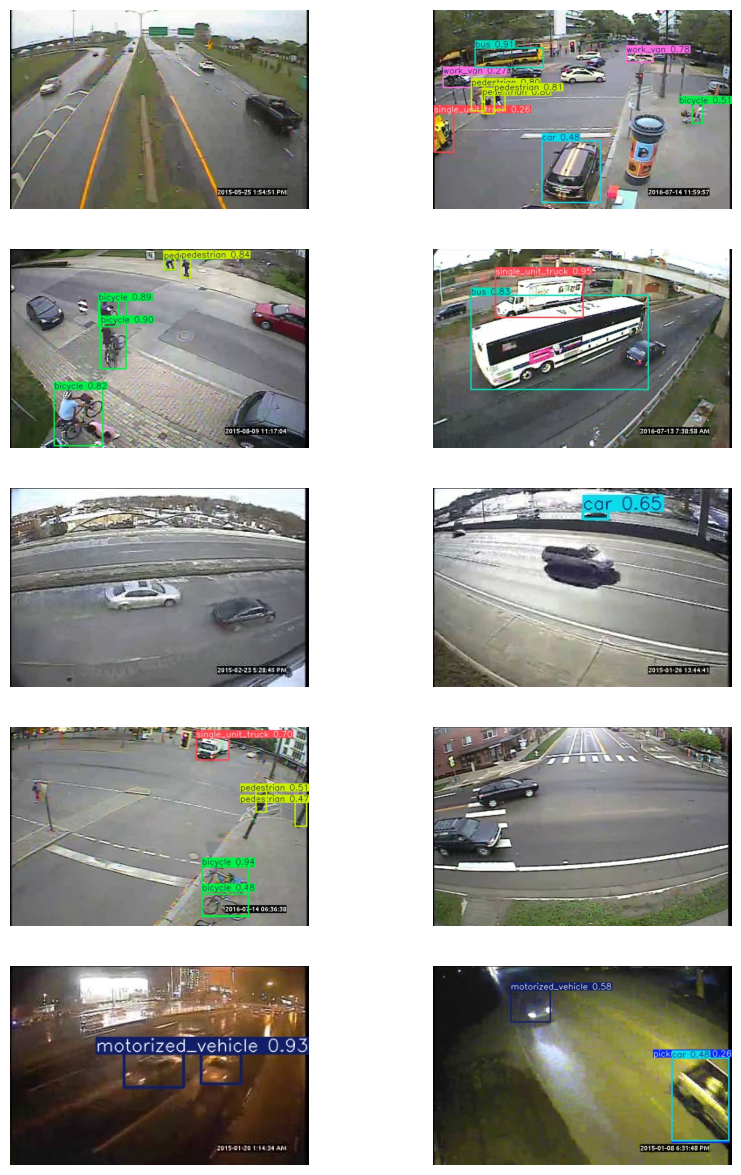

In [32]:
import matplotlib.pyplot as plt

imgs = []
for i in range(10):
  img = cv2.imread(root_dir + "/results/" + valImgs[i])
  img = img[...,::-1] # Convert BGR2RGB for display using matplotlib
  imgs.append(img)

def plot_ten_images(imgs):
  plt.figure(figsize=(10,15))
  for i, img in enumerate(imgs):
    plt.subplot(5,2,i+1)
    plt.imshow(img)
    plt.axis('off')
  plt.show()

plot_ten_images(imgs)

## 6. Summary and Conclusion

1. The training process took `1.746` hours.
2. The inferences are satisfactory, considering the available data and limited training.

To achieve better results, the following steps could be taken:
1. The data is highly imbalanced, and better results might have been obtained with more balanced data.
2. Data augmentation could have been used to address the imbalance, though this would require more robust hardware.
3. Training could have been extended beyond the current limit of `100` epochs.


## References

<a id="1">[1]</a>
Train YOLOv8 on Custom Dataset – A Complete Tutorial https://learnopencv.com/train-yolov8-on-custom-dataset/#The-Pothole-Detection-Dataset-to-Train-YOLOv8

<a id="2">[2]</a>
Python Usage - Ultralytics https://docs.ultralytics.com/usage/python/

<a id="3">[3]</a>
Object Detection Datasets Overview - Ultralytics https://docs.ultralytics.com/datasets/detect/

<a id="4">[4]</a>
COCO8 Dataset - Ultralytics https://docs.ultralytics.com/datasets/detect/coco8/

<a id="5">[5]</a>
Train - Ultralytics https://docs.ultralytics.com/modes/train/#resuming-interrupted-trainings

<a id="6">[6]</a>
Predict - Ultralytics https://docs.ultralytics.com/modes/predict/#introduction